# Adaptive network dynamics: The $n$-block case

In [4]:
# import some packages
import re
from matplotlib import pyplot as plt
import numpy as np
import sympy as sy
# import sympy functions
from sympy import Eq, Function, Derivative, Matrix, Max, Abs, binomial, hyper, Sum, sqrt
from IPython.display import display

In [5]:
def remove_special_characters(string):
    return re.sub('[^A-Za-z0-9]+', '', str(string))

# define some useful functions
# scalar-valued distance function
p = sy.symbols('p', positive=True)
distance = lambda i1, i2 : (Abs(i1-i2))**p

# vector-valued functions
# Left multiplication of square matrix to vector
def matrix_vector_mult(A_2dlist, x_list):
    n = len(x_list)
    Ax = [sum([A_2dlist[i][j]*x_list[j] for j in range(n)]) 
          for i in range(n)]
    return Ax
# shortcut
mvmult = lambda A_2dlist, x_list : matrix_vector_mult(A_2dlist, x_list)

# matrix-valued functions
def distance_matrix(x_list):
    n = len(x_list)
    distmat = [[distance(x_list[i], x_list[j]) for j in range(n)] 
               for i in range(n)]
    return distmat

# degree matrix
def degree_matrix(A_2dlist, degree='in'):
    
    n = len(A_2dlist)
    Dmat = [[0 for j in range(n)] for i in range(n)]
    
    if degree=='in':
        for i in range(n):
            Dmat[i][i] = sum([A_2dlist[i][j] for j in range(n)])
    elif degree=='out':
        for i in range(n):
            Dmat[i][i] = sum([A_2dlist[j][i] for j in range(n)])
    else:
        print('Unknown degree type. Return zero matrix.')
        
    return Dmat

# matrix subtraction
def msubs(A_2dlist, B_2dlist):
    
    n = len(A_2dlist)
    subs = [[A_2dlist[i][j] - B_2dlist[i][j] for j in range(n)]
        for i in range(n)]
    
    return subs

# laplace matrix
def laplace_matrix(A_2dlist, degree='in'):
    Lmat = msubs(degree_matrix(A_2dlist, degree=degree), A_2dlist)
    return Lmat


# plotting functions
def plot_streamplot(A, ax, figtitle=None):
    """
    Show a stream plot for a linear ordinary differential equation with
    state vector x=[x1,x2] in axis ax.

    Args:
      A (numpy array): 2x2 matrix specifying the dynamical system
      figtitle (string): title for the figure

    Returns:
      nothing, but shows a figure
    """

    # sample 20 x 20 grid uniformly to get x1 and x2
    grid = np.arange(-20, 21, 1)
    x1, x2 = np.meshgrid(grid, grid)

    # calculate x1dot and x2dot at each grid point
    x1dot = A[0,0] * x1 + A[0,1] * x2
    x2dot = A[1,0] * x1 + A[1,1] * x2

    # make a colormap
    magnitude = np.sqrt(x1dot ** 2 + x2dot ** 2)
    color = 2 * np.log1p(magnitude) #Avoid taking log of zero

    # plot
    plt.sca(ax)
    plt.streamplot(x1, x2, x1dot, x2dot, color=color,
                   linewidth=1, cmap=plt.cm.cividis,
                   density=2, arrowstyle='->', arrowsize=1.5)
    plt.xlabel(r'$x1$')
    plt.ylabel(r'$x2$')

    # figure title
    if figtitle is not None:
        plt.title(figtitle, size=16)

    # include eigenvectors
    if True:
        # get eigenvalues and eigenvectors of A
        lam, v = np.linalg.eig(A)

        # get eigenvectors of A
        eigenvector1 = v[:,0].real
        eigenvector2 = v[:,1].real

        # plot eigenvectors
        plt.arrow(0, 0, 20*eigenvector1[0], 20*eigenvector1[1],
                  width=0.5, color='r', head_width=2,
                  length_includes_head=True)
        plt.arrow(0, 0, 20*eigenvector2[0], 20*eigenvector2[1],
                  width=0.5, color='b', head_width=2,
                  length_includes_head=True)

def streamPlots(A_options):
    """
    Show a stream plot for each A in A_options

    Args:
      A (list): a list of numpy arrays (each element is A)

    Returns:
      nothing, but shows a figure
    """
    # get stream plots for the four different systems
    plt.figure(figsize=(10,10))

    for i, A in enumerate(A_options):

        ax = plt.subplot(2, 2, 1+i)
        # get eigenvalues and eigenvectors
        lam, v = np.linalg.eig(A)

        # plot eigenvalues as title
        # (two spaces looks better than one)
        eigstr = ",  ".join([f"{x:.2f}" for x in lam])
        figtitle =f"A with eigenvalues\n"+ '[' + eigstr + ']'
        plot_streamplot(A, ax, figtitle=figtitle)

        # Remove y_labels on righthand plots
        if i%2:
          ax.set_ylabel(None)
        if i<2:
          ax.set_xlabel(None)

        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        
def vectorfield3d(jacobian, variables, indices=[0,1], parameters=[], verbose=False):
    
    # make reduced state vector
    used_variables = [variables[i] for i in indices]
    vec = Matrix(used_variables)
    
    for v in [i.func for i in vec.atoms(Function)]:
        v_str = str(v)
        clean_v_str = remove_special_characters(v_str)
        if v_str != clean_v_str:
            parameters += [[Function(v_str)(t), sy.symbols(clean_v_str)]]
            vec = vec.subs(v(t), sy.symbols(clean_v_str))
    if verbose:
        print('vec')
        display(vec)
    
    # make reduced matrix
    mat = Matrix(jacobian)
    if verbose:
        print('mat')
        display(mat)
    for name, val in parameters:
        mat = mat.subs(name, val)
    if verbose:
        print('mat')
        display(mat)
    mat = mat[indices, indices]
    if verbose:
        print('mat')
        display(mat)
    
    df = mat*vec
    if verbose:
        print('df')
        display(df)
    
    if df[0].has(vec[0]) and df[0].has(vec[1]):
        u = sy.lambdify(tuple(vec), df[0], 'numpy')
    elif df[0].has(vec[0]):
        u_ = sy.lambdify((vec[0]), df[0], 'numpy')
        u = lambda i1, i2: np.kron(v_(i1),np.ones(i2.shape))
    elif df[0].has(vec[1]):
        u_ = sy.lambdify((vec[1]), df[0], 'numpy')
        u = lambda i1, i2: np.kron(np.ones(i1.shape),v_(i2))
    else:
        print('zero gradient detected for u')
        u = lambda i1, i2: np.zeros((i1.shape[1],i2.shape[0]))
        
    if df[1].has(vec[0]) and df[1].has(vec[1]):
        v = sy.lambdify(tuple(vec), df[1], 'numpy')
    elif df[1].has(vec[0]):
        v_ = sy.lambdify((vec[0]), df[1], 'numpy')
        v = lambda i1, i2: np.kron(v_(i1),np.ones(i2.shape))
    elif df[1].has(vec[1]):
        v_ = sy.lambdify((vec[1]), df[1], 'numpy')
        v = lambda i1, i2: np.kron(np.ones(i1.shape),v_(i2))
    else:
        print('zero gradient detected for v')
        v = lambda i1, i2: np.zeros((i1.shape[1],i2.shape[0]))     
    
    return u, v

def vectorfield2d(arg1, variables, parameters=[], verbose=False):
       
    # make reduced state vector
    used_variables = variables
    vec = Matrix(used_variables)
    
    for v in [i.func for i in vec.atoms(Function)]:
        v_str = str(v)
        clean_v_str = remove_special_characters(v_str)
        if v_str != clean_v_str:
            parameters += [[Function(v_str)(t), sy.symbols(clean_v_str)]]
            vec = vec.subs(v(t), sy.symbols(clean_v_str))
    if verbose:
        print('vec')
        display(vec)

    if isinstance(arg1, Matrix):
        jacobian = arg1

        # make reduced matrix
        mat = Matrix(jacobian)
        if verbose:
            print('mat')
            display(mat)
        for name, val in parameters:
            mat = mat.subs(name, val)
        if verbose:
            print('mat')
            display(mat)

        df = mat*vec
            
    elif isinstance(arg1, list):
        sys = arg1
        df = [sys[0].rhs, sys[1].rhs]
        
        if verbose:
            print('sys')
            display(df)
        
        for name, val in parameters:
            for i in range(2):
                df[i] = df[i].subs(name, val)

        if verbose:
            print('sys')
            display(df)

    else:
        print("Unknown type for arg1. Must be sympy matrix or list of equations.")
        return 0

    if verbose:
        print('df')
        display(df)

    if df[0].has(vec[0]) and df[0].has(vec[1]):
        u = sy.lambdify(tuple(vec), df[0], 'numpy')
    elif df[0].has(vec[0]):
        u_ = sy.lambdify((vec[0]), df[0], 'numpy')
        u = lambda i1, i2: np.kron(v_(i1),np.ones(i2.shape))
    elif df[0].has(vec[1]):
        u_ = sy.lambdify((vec[1]), df[0], 'numpy')
        u = lambda i1, i2: np.kron(np.ones(i1.shape),v_(i2))
    else:
        print('zero gradient detected for u')
        u = lambda i1, i2: np.zeros((i1.shape[1],i2.shape[0]))
        
    if df[1].has(vec[0]) and df[1].has(vec[1]):
        v = sy.lambdify(tuple(vec), df[1], 'numpy')
    elif df[1].has(vec[0]):
        v_ = sy.lambdify((vec[0]), df[1], 'numpy')
        v = lambda i1, i2: np.kron(v_(i1),np.ones(i2.shape))
    elif df[1].has(vec[1]):
        v_ = sy.lambdify((vec[1]), df[1], 'numpy')
        v = lambda i1, i2: np.kron(np.ones(i1.shape),v_(i2))
    else:
        print('zero gradient detected for v')
        v = lambda i1, i2: np.zeros((i1.shape[1],i2.shape[0]))     
    
    return u, v

def plot_streamlines(ax, u, v, xlim=(-1, 1), ylim=(-1, 1), verbose=False):
    x0, x1 = xlim
    y0, y1 = ylim
    Y, X =  np.ogrid[y0:y1:100j, x0:x1:100j]
    
    if verbose:
        print('x', X.shape)
        print('y', Y.shape)
        try:
            print('u', u(X,Y).shape)
        except:
            print('u', u(X,Y))
        try:
            print('v', v(X,Y).shape)
        except:
            print('v', v(X,Y))
    uxy = u(X,Y)
    vxy = v(X,Y)
    speed = np.sqrt(uxy**2 + vxy**2)
    try: 
        ax.streamplot(X, Y, uxy, vxy, color=speed, linewidth=2, cmap='autumn')
    except:
        ax.streamplot(X, Y, uxy, vxy, color='cornflowerblue', linewidth=2)

## 1 First model and $n$-block structure

### 1.1 Model with varying total edge weight
We start with a model in which neither edge density nor degrees are conserved. We have a (possibly) directed, weighted graph $G=(V,E, W(t))$ with $N=|V|$ nodes, weights $W(t):E\times E \rightarrow \mathbb{R}^{\geq0}$, and adjacency matrix $A^{(\textrm{full})}(t)\in \mathbb{R}^{N\times N}$. The node set is fixed. Admitting zero-valued edge weights, we can assume wlog that the edge set $E$ is complete. Each node $i\in V$ is associated with an opinion state $x_i(t)$. Opinion states and edge weights evolve according to

$$\begin{align}\dot x &= -Lx \\
\alpha\dot A^{(\textrm{full})}_{ij} &= A^{(\textrm{full})}_{ij}(\tau-(|x_i-x_j|)^p)\,.\end{align}$$

The model includes a timescale parameter $\alpha$, a tolerance parameter $\tau$, and a parameter $p\in {1,2, \dots}$ to select a norm used to measure distances between states.

## 1.2 The $n$-block stucture

When two nodes $i$ and $j$ have identical neighborhoods (including identical edge weights) and identical initial conditions $x_i(0)=x_j(0)$, we know that $x_i(t)=x_j(t)$ for all $t$, and we can reduce the number of equations accordingly. Precisely, if one can group all nodes into $n$ groups of nodes $V_k$ with $k={1,\dots, n}$ such that a swap of any two nodes $i,j\in V_k$ for any $k$ is an automorphism on $G$ and $x_i(0)=x_j(0)$, we can reduce the system of ODEs from $N^2+N$ to $n^2+n$ equations. We then say that $G$ and $x(0)$ have an $n$-block structure. One can describe the structure of this system using a reduced adjacency matrix $A(t)\in \mathbb{R}^{n\times n}$.

The code below produces the $n^2+n$ equations for an $n$-block structure.

## 1.3 The 2-block structure

### 1.3.1 Model equations for the 2-block structure

In [6]:
# Define general system

# system size (number of blocks)
n = 2

# define parameters
alpha, tau = sy.symbols(r'\alpha'), sy.symbols(r'\tau')

# define variables
t = sy.symbols('t')
x = [Function('x_'+str(i+1))(t) for i in range(n)]
A = [[Function('A_{'+str(i+1)+','+str(j+1)+'}')(t) for j in range(n)] for i in range(n)]

# define equations
# equations for x
x_eqs = [Eq(Derivative(x[i],t), -mvmult(laplace_matrix(A, degree='in'),x)[i]) for i in range(n)]
# equations for A
A_eqs = [Eq(Derivative(A[i][j],t),alpha**(-1)*A[i][j]*(tau-distance_matrix(x)[i][j])) for i in range(n) for j in range(n)]
# all equations
system = x_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(x_1(t), t), -A_{1,2}(t)*x_1(t) + A_{1,2}(t)*x_2(t))

Eq(Derivative(x_2(t), t), A_{2,1}(t)*x_1(t) - A_{2,1}(t)*x_2(t))

Eq(Derivative(A_{1,1}(t), t), \tau*A_{1,1}(t)/\alpha)

Eq(Derivative(A_{1,2}(t), t), (\tau - Abs(x_1(t) - x_2(t))**p)*A_{1,2}(t)/\alpha)

Eq(Derivative(A_{2,1}(t), t), (\tau - Abs(x_1(t) - x_2(t))**p)*A_{2,1}(t)/\alpha)

Eq(Derivative(A_{2,2}(t), t), \tau*A_{2,2}(t)/\alpha)

### 1.3.2 Some model reductions

#### 1.3.2.1 Separation of the subspace of within-group edge weights
We see that the diagonal elements of $A$ evolve independently from each other and from everything else in the system, so we can separate them from the remaining $n^2$ equations. 

Each of the equations the diagonal elements of $A(t)$ indicates exponential growth of a diagonal element $A_{ii}(t)$. In each subspace corresponding to a variable $A_{ii}(t)$, there is a single fixed point at $A_{ii}=0$, and this fixed point is unstable. So the system of $n^2+n$ equations does not have stable fixed points.

We now investigate the stability of the subsystem corresponding to the remaining $n^2$ equations.

In [7]:
# define equations
# equations for x
x_eqs = [Eq(Derivative(x[i],t), -mvmult(laplace_matrix(A, degree='in'),x)[i]) for i in range(n)]
# equations for A
A_eqs = [Eq(Derivative(A[i][j],t), alpha**(-1)*A[i][j]*(tau-distance_matrix(x)[i][j])) for i in range(n) for j in range(n) if j!=i]
# all equations
system = x_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(x_1(t), t), -A_{1,2}(t)*x_1(t) + A_{1,2}(t)*x_2(t))

Eq(Derivative(x_2(t), t), A_{2,1}(t)*x_1(t) - A_{2,1}(t)*x_2(t))

Eq(Derivative(A_{1,2}(t), t), (\tau - Abs(x_1(t) - x_2(t))**p)*A_{1,2}(t)/\alpha)

Eq(Derivative(A_{2,1}(t), t), (\tau - Abs(x_1(t) - x_2(t))**p)*A_{2,1}(t)/\alpha)

#### 1.3.2.2 Replacing opinions by discordance variable

In the 2-block case, we see that the variables depend on the difference $x_1-x_2$ but not on the values of $x_1$ and $x_2$ independently. We define a variable $\chi(t):=x_1(t)-x_2(t)$ with initial condition $\chi(0)=x_1(0)-x_2(0)$. We can thus describe the dynamics of the system in three equations:

In [8]:
# define variable
chi = Function(r'\chi', real=True)(t)

# define equations
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(x[0],chi+x[1])))]
# equations for A
A_eqs = [Eq(Derivative(A[i][j],t), alpha**(-1)*A[i][j]*(tau-Abs(chi)**p)) for i in range(n) for j in range(n) if j!=i]
# all equations
system = chi_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -(A_{1,2}(t) + A_{2,1}(t))*\chi(t))

Eq(Derivative(A_{1,2}(t), t), (\tau - Abs(\chi(t))**p)*A_{1,2}(t)/\alpha)

Eq(Derivative(A_{2,1}(t), t), (\tau - Abs(\chi(t))**p)*A_{2,1}(t)/\alpha)

We see that there is a non-zero change of opinions over time when the system is in consensus (i.e., $\chi=0$) or when all non-diagonal elements of $A$ are zero (i.e., $A_{1,2}=A_{2,1}=0$, assuming that we only allow non-negative edge weights). The time evolution for the edge weights are zero if the discordance in the system is just at the tolerance threshold (i.e., $|\chi|^p=\tau$) or when there is no coupling between the node groups (i.e., $A_{1,2}=A_{2,1}=0$). The $\chi=0$ plane, the  $A_{1,2}=A_{2,1}=0$, and the $|\chi|^p=\tau$ manifold should interesting to study closely. 

#### 1.3.2.3 Transform $A$ variables

Do a transformation 

$$\begin{align}
s_1:&=A_{12}+A_{21}\\
s_2:&=A_{11}+A_{22}\\
d_1:&=A_{12}-A_{21}\\
d_2:&=A_{11}-A_{22}
\end{align}$$

In [13]:
# define equations
s1, s2, d1, d2 = Function('s_1')(t), Function('s_2')(t), Function('d_1')(t), Function('d_2')(t)
subs = {x[0] : chi+x[1], A[0][1] : s1-A[1][0], A[0][1]-A[1][0] : d1}
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(subs)))]
# equations for A
sd_eqs = [Eq(Derivative(s1), sy.simplify(A_eqs[0].rhs+A_eqs[1].rhs).subs(subs)),
          Eq(Derivative(d1), sy.simplify(A_eqs[0].rhs-A_eqs[1].rhs).subs(subs))]
#A_eqs = [[Eq(Derivative(A[i][j],t), alpha**(-1)*A[i][j]*(tau-Abs(chi)**p)) for i in range(n) for j in range(n) if j!=i][0]]
# all equations
system = chi_eqs + sd_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -\chi(t)*s_1(t))

Eq(Derivative(s_1(t), t), (\tau - Abs(\chi(t))**p)*s_1(t)/\alpha)

Eq(Derivative(d_1(t), t), (\tau - Abs(\chi(t))**p)*d_1(t)/\alpha)

The third equation is downstream of the first two. So only $\chi$ and $s_1$ drive the evolution of this system.

Let us look at the Jacobian of this system for $p\in\{1,2\}$.

## 1.4 Results for the 2-block case

### 1.4.1 Results for $p=2$

In [15]:
X = Matrix([chi, s1])
FX = Matrix([system[i].rhs for i in range(2)])
J2 = FX.subs(p,2).jacobian(X)
display(J2)

Matrix([
[                 -s_1(t),                   -\chi(t)],
[-2*\chi(t)*s_1(t)/\alpha, (\tau - \chi(t)**2)/\alpha]])

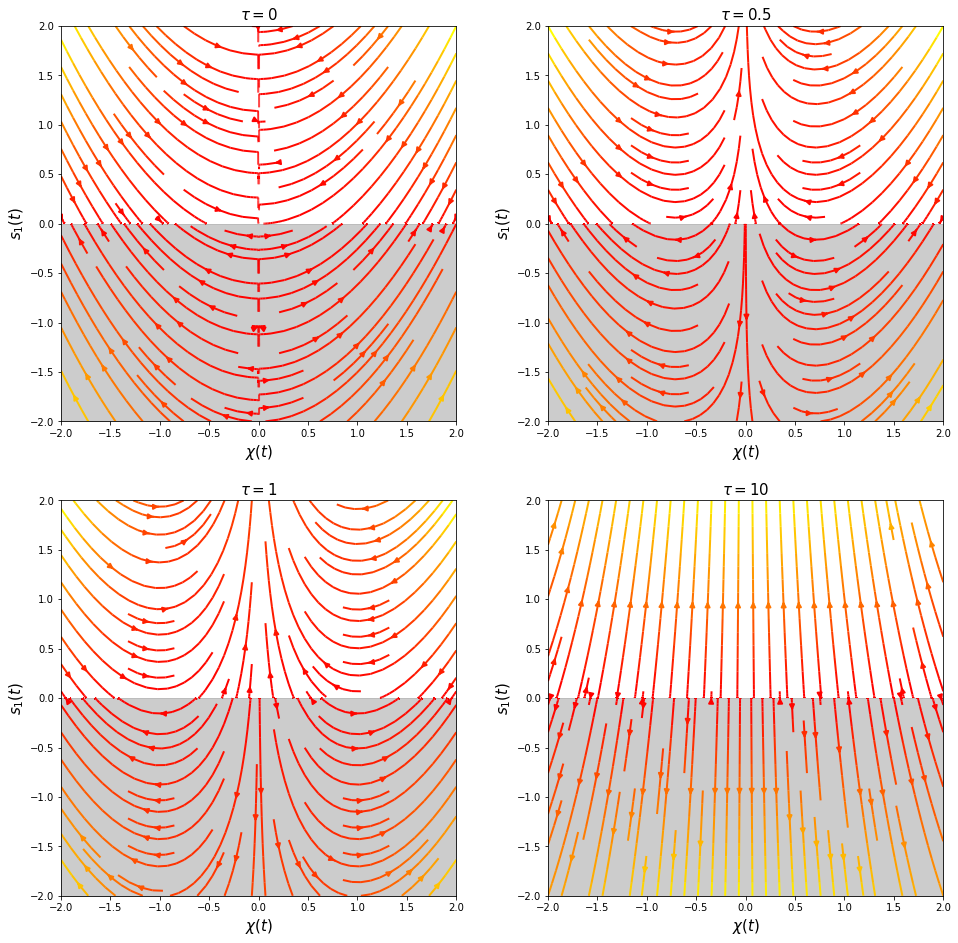

In [16]:
xlim = (-2, 2)
ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0,0.5,1,10]):
    ax = plt.subplot(2,2,1+i)
    
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,2],[tau, val],[alpha,1]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\tau=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

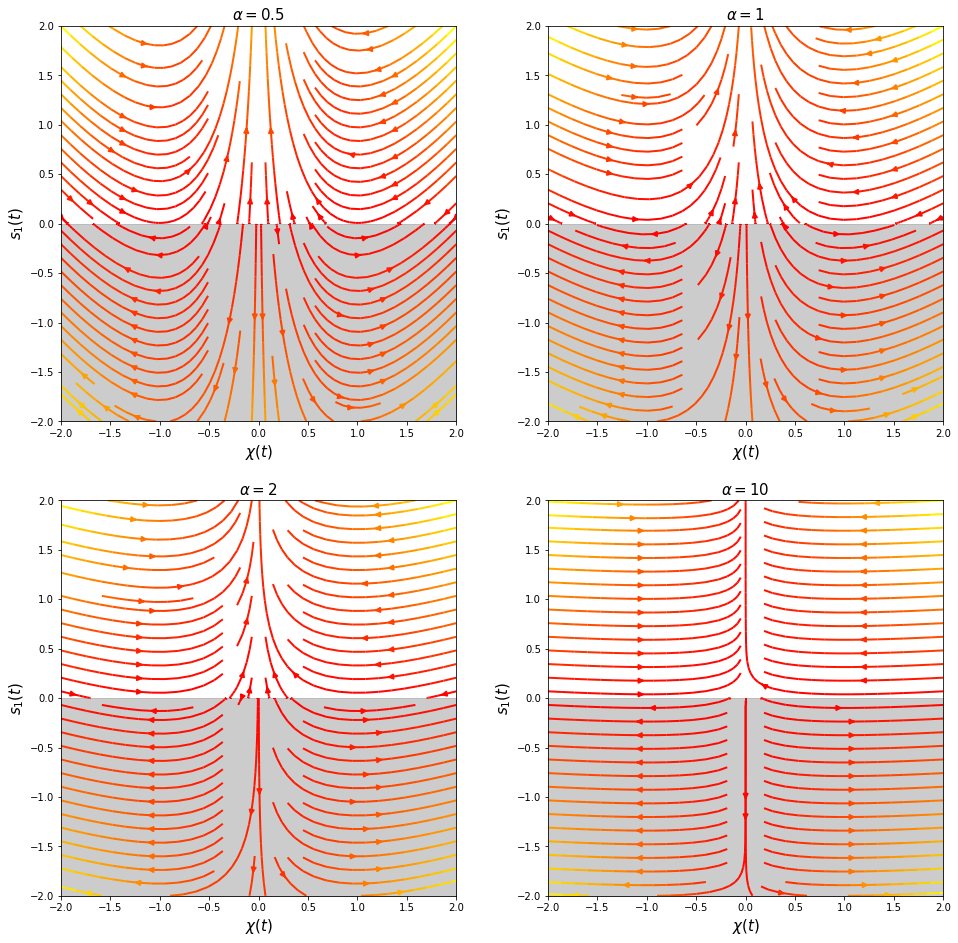

In [17]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0.5,1,2,10]):
    ax = plt.subplot(2,2,1+i)
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,1],[tau, 1],[alpha,val]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\alpha=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

### 1.4.2 Results for $p=1$

In [18]:
X = Matrix([chi, s1])
FX = Matrix([system[i].rhs for i in range(2)])
J1 = FX.subs(p,1).jacobian(X)
print('Jacobian')
display(J1)
print(r'Jacobian, assuming that $\chi(t)\neq 0$')
J1[1,0] = J1[1,0]/Derivative(chi,chi)
display(J1)

Jacobian


Matrix([
[                                                  -s_1(t),                     -\chi(t)],
[-s_1(t)*sign(\chi(t))*Derivative(\chi(t), \chi(t))/\alpha, (\tau - Abs(\chi(t)))/\alpha]])

Jacobian, assuming that $\chi(t)\neq 0$


Matrix([
[                     -s_1(t),                     -\chi(t)],
[-s_1(t)*sign(\chi(t))/\alpha, (\tau - Abs(\chi(t)))/\alpha]])

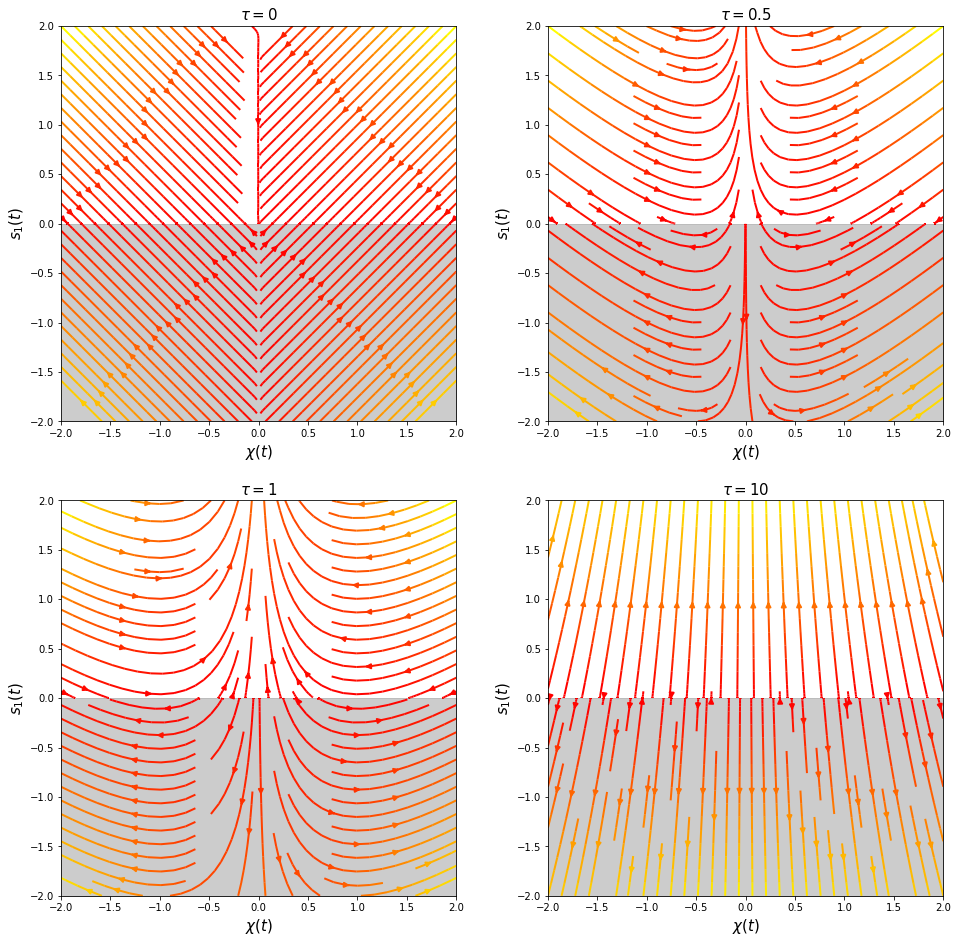

In [19]:
xlim = (-2, 2)
ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0,0.5,1,10]):
    ax = plt.subplot(2,2,1+i)
    
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,1],[tau, val],[alpha,1]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\tau=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

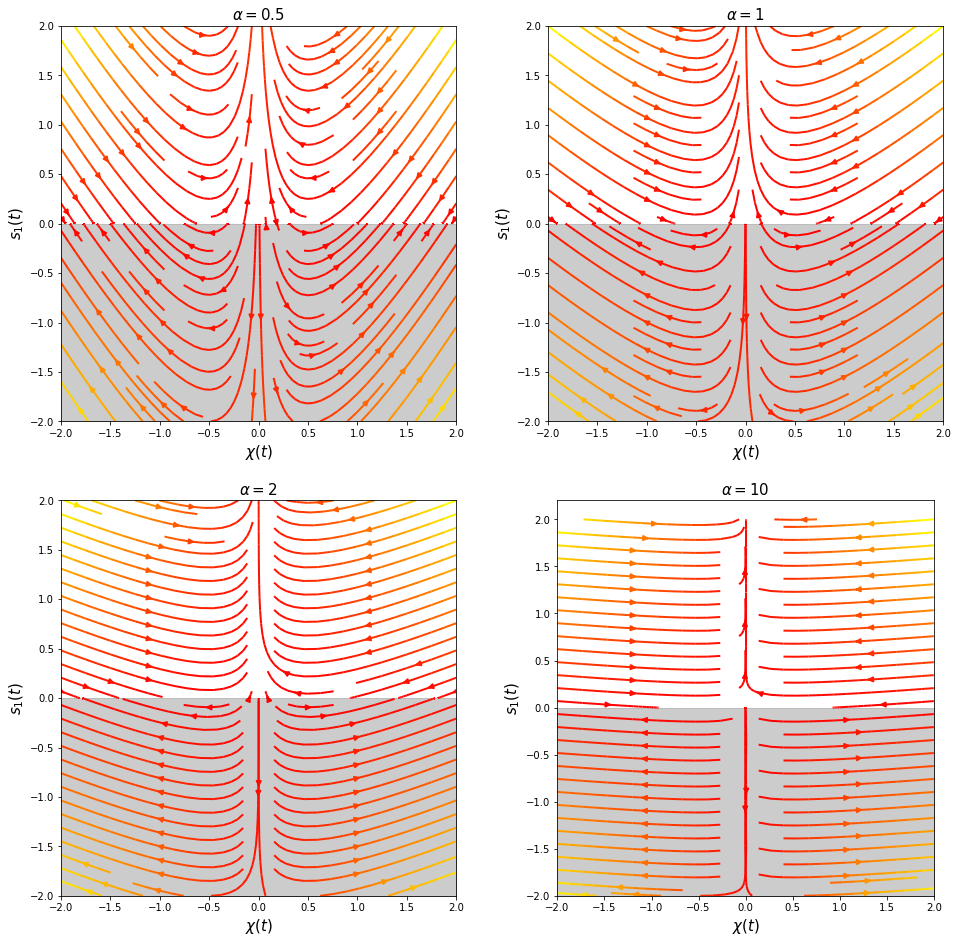

In [20]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0.5,1,2,10]):
    ax = plt.subplot(2,2,1+i)
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    
    vec = [chi, s1]
    u, v = vectorfield2d(J1, vec, parameters=[[p,1],[tau, 1],[alpha,val]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\alpha=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

# 2 Model with constant edge density

## 2.1. Model equations

$$\begin{align}\dot x &= -Lx \\
\alpha\dot A^{(\textrm{full})}_{ij} &= A^{(\textrm{full})}_{ij}(\tau-(|x_i-x_j|)^p)-\binom{N}{2}^{-1}\sum_{\substack{1\leq i,j\leq N\\j\neq i}}A^{(\textrm{full})}_{ij}(\tau-(|x_i-x_j|)^p)\,.\end{align}$$

## 2.2 The $n$-block case:

$$\begin{align}\dot x &= -Lx \\
\alpha\dot A_{ij} &= A_{ij}(\tau-(|x_i-x_j|)^p)-\frac{1}{n^2}\sum_{\substack{1\leq i,j\leq n}}A_{ij}(\tau-(|x_i-x_j|)^p)\,.\end{align}$$

## 2.3 The 2-block case

### 2.3.1 Model equations

In [23]:
# Define general system

# system size (number of blocks)
n = 2

# define parameters
alpha, tau = sy.symbols(r'\alpha'), sy.symbols(r'\tau')

# define variables
t = sy.symbols('t')
x = [Function('x_'+str(i+1))(t) for i in range(n)]
A = [[Function('A_{'+str(i+1)+','+str(j+1)+'}')(t) for j in range(n)] for i in range(n)]

# define equations
# equations for x
x_eqs = [Eq(Derivative(x[i],t), -mvmult(laplace_matrix(A, degree='in'),x)[i]) for i in range(n)]
# equations for A
c = sum([A[i][j]*(tau-distance_matrix(x)[i][j]) for i in range(n) for j in range(n)])/n**2
A_eqs = [Eq(Derivative(A[i][j],t),sy.simplify(alpha**(-1)*(A[i][j]*(tau-distance_matrix(x)[i][j])-c))) for i in range(n) for j in range(n)]
# all equations
system = x_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(x_1(t), t), -A_{1,2}(t)*x_1(t) + A_{1,2}(t)*x_2(t))

Eq(Derivative(x_2(t), t), A_{2,1}(t)*x_1(t) - A_{2,1}(t)*x_2(t))

Eq(Derivative(A_{1,1}(t), t), (3*\tau*A_{1,1}(t) - \tau*A_{2,2}(t) - (\tau - Abs(x_1(t) - x_2(t))**p)*A_{1,2}(t) - (\tau - Abs(x_1(t) - x_2(t))**p)*A_{2,1}(t))/(4*\alpha))

Eq(Derivative(A_{1,2}(t), t), (-\tau*A_{1,1}(t) - \tau*A_{2,2}(t) + 3*(\tau - Abs(x_1(t) - x_2(t))**p)*A_{1,2}(t) - (\tau - Abs(x_1(t) - x_2(t))**p)*A_{2,1}(t))/(4*\alpha))

Eq(Derivative(A_{2,1}(t), t), (-\tau*A_{1,1}(t) - \tau*A_{2,2}(t) - (\tau - Abs(x_1(t) - x_2(t))**p)*A_{1,2}(t) + 3*(\tau - Abs(x_1(t) - x_2(t))**p)*A_{2,1}(t))/(4*\alpha))

Eq(Derivative(A_{2,2}(t), t), (-\tau*A_{1,1}(t) + 3*\tau*A_{2,2}(t) - (\tau - Abs(x_1(t) - x_2(t))**p)*A_{1,2}(t) - (\tau - Abs(x_1(t) - x_2(t))**p)*A_{2,1}(t))/(4*\alpha))

### 2.3.2 Model reduction

#### 2.3.2.1 Discordance variable
Substitute $\chi=x_1-x_2$ into system of equations.

In [24]:
# define variable
chi = Function(r'\chi', real=True)(t)
# define equations
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(x[0],chi+x[1])))]
# equations for A
c = sum([A[i][j]*(tau-int(i!=j)*Abs(chi)**p) for i in range(n) for j in range(n)])/n**2
A_eqs = [Eq(Derivative(A[i][j],t), sy.simplify(alpha**(-1)*(A[i][j]*(tau-int(i!=j)*Abs(chi)**p)-c))) for i in range(n) for j in range(n)]
# all equations
system = chi_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -(A_{1,2}(t) + A_{2,1}(t))*\chi(t))

Eq(Derivative(A_{1,1}(t), t), (3*\tau*A_{1,1}(t) - \tau*A_{2,2}(t) - (\tau - Abs(\chi(t))**p)*A_{1,2}(t) - (\tau - Abs(\chi(t))**p)*A_{2,1}(t))/(4*\alpha))

Eq(Derivative(A_{1,2}(t), t), (-\tau*A_{1,1}(t) - \tau*A_{2,2}(t) + 3*(\tau - Abs(\chi(t))**p)*A_{1,2}(t) - (\tau - Abs(\chi(t))**p)*A_{2,1}(t))/(4*\alpha))

Eq(Derivative(A_{2,1}(t), t), (-\tau*A_{1,1}(t) - \tau*A_{2,2}(t) - (\tau - Abs(\chi(t))**p)*A_{1,2}(t) + 3*(\tau - Abs(\chi(t))**p)*A_{2,1}(t))/(4*\alpha))

Eq(Derivative(A_{2,2}(t), t), (-\tau*A_{1,1}(t) + 3*\tau*A_{2,2}(t) - (\tau - Abs(\chi(t))**p)*A_{1,2}(t) - (\tau - Abs(\chi(t))**p)*A_{2,1}(t))/(4*\alpha))

#### 2.3.2.2 Transform $A$ variables

Do a transformation 

$$\begin{align}
s_1:&=A_{12}+A_{21}\\
s_2:&=A_{11}+A_{22}\\
d_1:&=A_{12}-A_{21}\\
d_2:&=A_{11}-A_{22}
\end{align}$$

In [28]:
# define equations
subs = {x[0] : chi+x[1], A[0][1] : s1-A[1][0], A[0][0] : s2-A[1][1], A[1][0] : (s1-d1)/2, A[1][1] : (s2-d2)/2}
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(subs)))]
# equations for A
sd_eqs = [Eq(Derivative(s1), sy.simplify((A_eqs[1].rhs+A_eqs[2].rhs).subs(subs))),
          Eq(Derivative(s2), sy.simplify((A_eqs[0].rhs+A_eqs[3].rhs).subs(subs))),
          Eq(Derivative(d1), sy.simplify((A_eqs[1].rhs-A_eqs[2].rhs).subs(subs))),
          Eq(Derivative(d2), sy.simplify((A_eqs[0].rhs-A_eqs[3].rhs).subs(subs)))]
#A_eqs = [[Eq(Derivative(A[i][j],t), alpha**(-1)*A[i][j]*(tau-Abs(chi)**p)) for i in range(n) for j in range(n) if j!=i][0]]
# all equations
system = chi_eqs + sd_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -\chi(t)*s_1(t))

Eq(Derivative(s_1(t), t), (\tau*s_1(t) - \tau*s_2(t) - s_1(t)*Abs(\chi(t))**p)/(2*\alpha))

Eq(Derivative(s_2(t), t), (-\tau*s_1(t) + \tau*s_2(t) + s_1(t)*Abs(\chi(t))**p)/(2*\alpha))

Eq(Derivative(d_1(t), t), (\tau - Abs(\chi(t))**p)*d_1(t)/\alpha)

Eq(Derivative(d_2(t), t), \tau*d_2(t)/\alpha)

$d_1$ is downstream of other variables, and $d_2$ is independent. Focus on the driving system $(\chi, s_1, s_2)$.

#### 2.3.2.3 Conservation of total edge weight

We see that the overall tie strength $s_1+s_2$ is conserved.

In [29]:
sy.simplify(system[1].rhs+system[2].rhs)

0

So, we are again down to two equations to describe the dynamics:

In [32]:
# define equations
C = sy.symbols('C')
subs = {x[0] : chi+x[1], A[0][1] : s1-A[1][0], A[0][0] : s2-A[1][1], A[1][0] : (s1-d1)/2, A[1][1] : (s2-d2)/2, s2: C-s1}
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(subs)))]
# equations for A
sd_eqs = [Eq(Derivative(s1), sy.simplify(sy.collect(sy.expand((A_eqs[1].rhs+A_eqs[2].rhs).subs(subs)),s1)))]
system = chi_eqs + sd_eqs
   
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -\chi(t)*s_1(t))

Eq(Derivative(s_1(t), t), (-C*\tau + (2*\tau - Abs(\chi(t))**p)*s_1(t))/(2*\alpha))

## 2.4 Results for model with total-edge-weight conservation

### 2.4.1 Results for $p=2$

In [33]:
X = Matrix([chi, s1])
FX = Matrix([system[i].rhs for i in range(2)])
J2 = FX.subs(p,2).jacobian(X)
display(J2)

Matrix([
[               -s_1(t),                         -\chi(t)],
[-\chi(t)*s_1(t)/\alpha, (2*\tau - \chi(t)**2)/(2*\alpha)]])

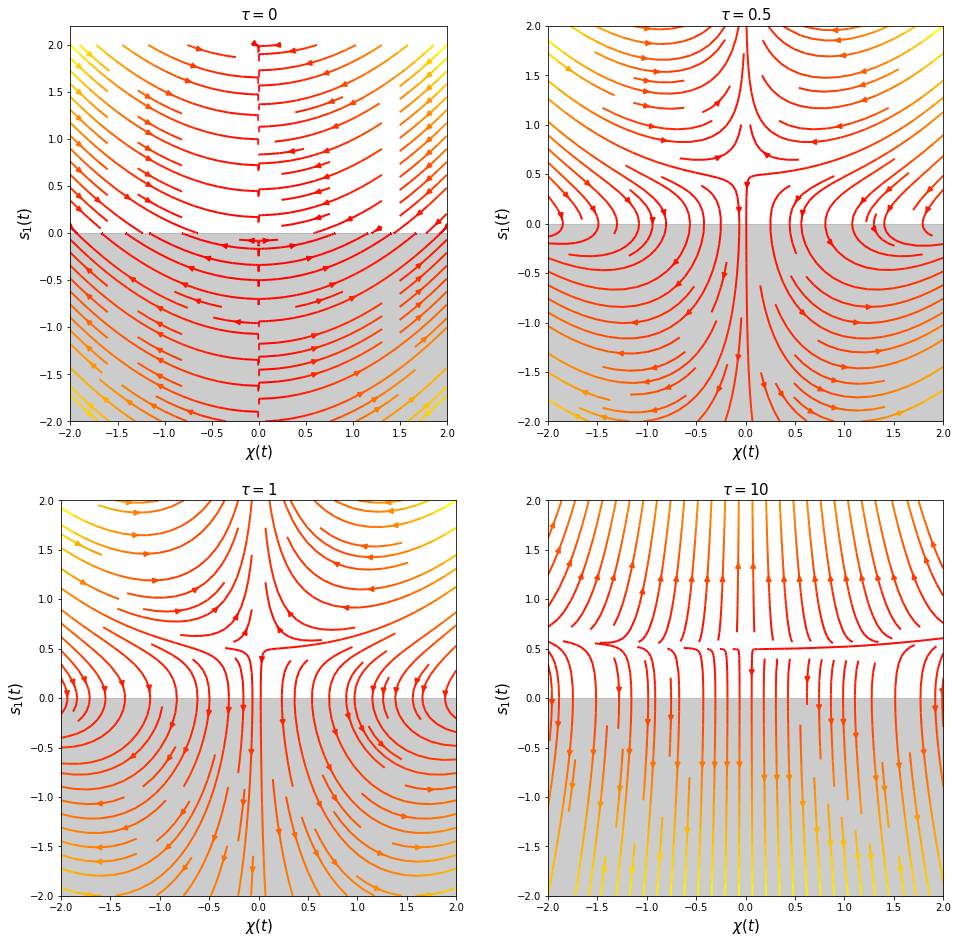

In [34]:
xlim = (-2, 2)
ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0,0.5,1,10]):
    ax = plt.subplot(2,2,1+i)
    
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,2],[C,1],[tau, val],[alpha,1]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\tau=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

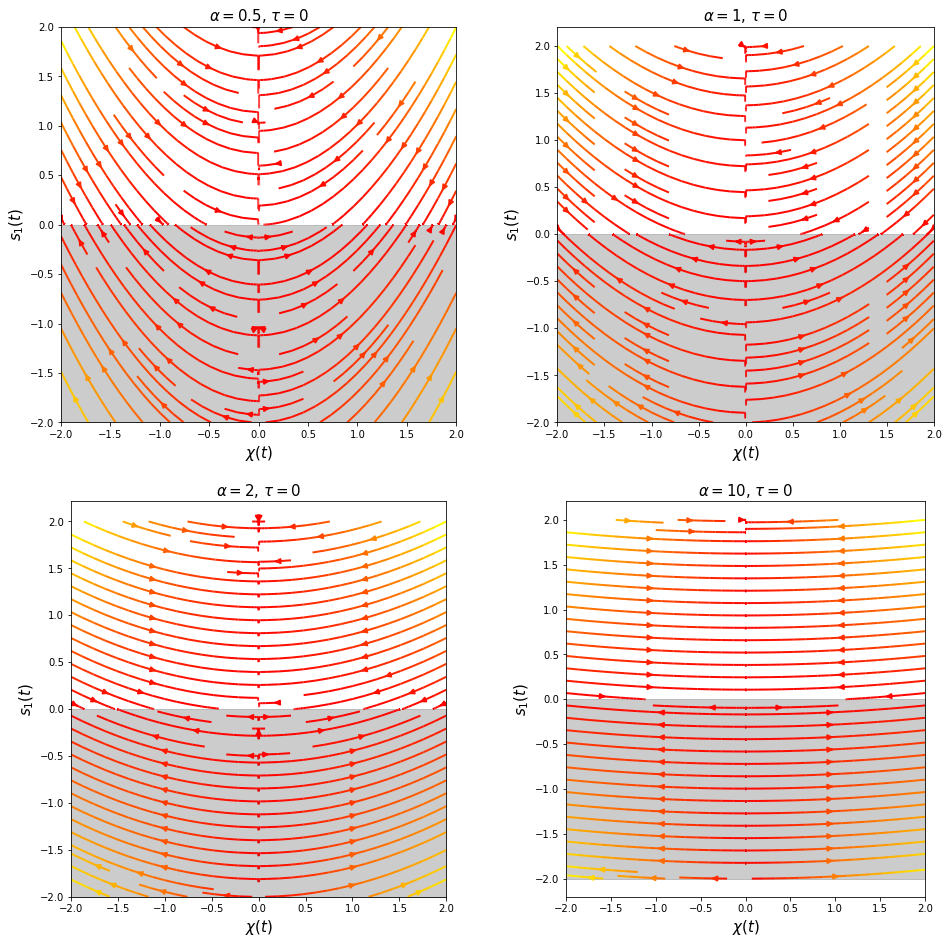

In [37]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0.5,1,2,10]):
    ax = plt.subplot(2,2,1+i)
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,2],[C,1],[tau, 0],[alpha,val]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\alpha=$'+str(val)+r', $\tau=$'+str(0), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

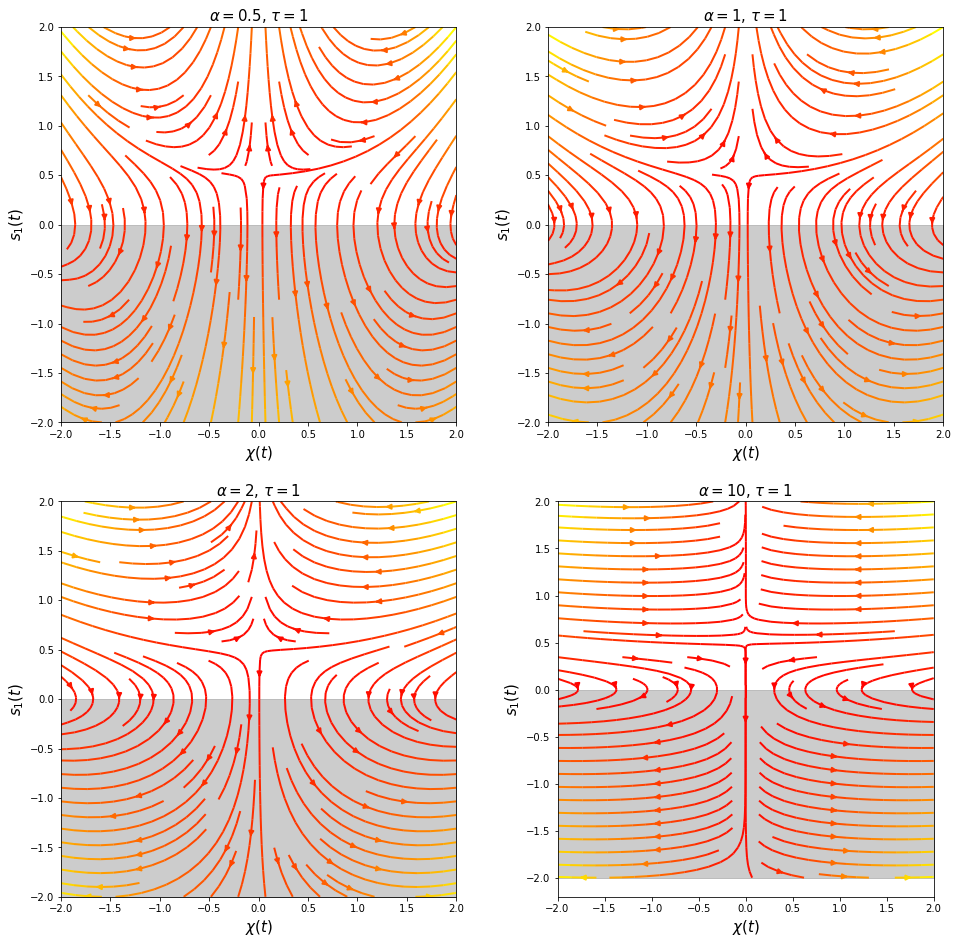

In [39]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0.5,1,2,10]):
    ax = plt.subplot(2,2,1+i)
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,2],[C,1],[tau, 1],[alpha,val]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\alpha=$'+str(val)+r', $\tau=$'+str(1), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

### 2.4.2 Results for $p=1$

In [40]:
X = Matrix([chi, s1])
FX = Matrix([system[i].rhs for i in range(2)])
J1 = FX.subs(p,1).jacobian(X)
display(J1)

Matrix([
[                                                      -s_1(t),                           -\chi(t)],
[-s_1(t)*sign(\chi(t))*Derivative(\chi(t), \chi(t))/(2*\alpha), (2*\tau - Abs(\chi(t)))/(2*\alpha)]])

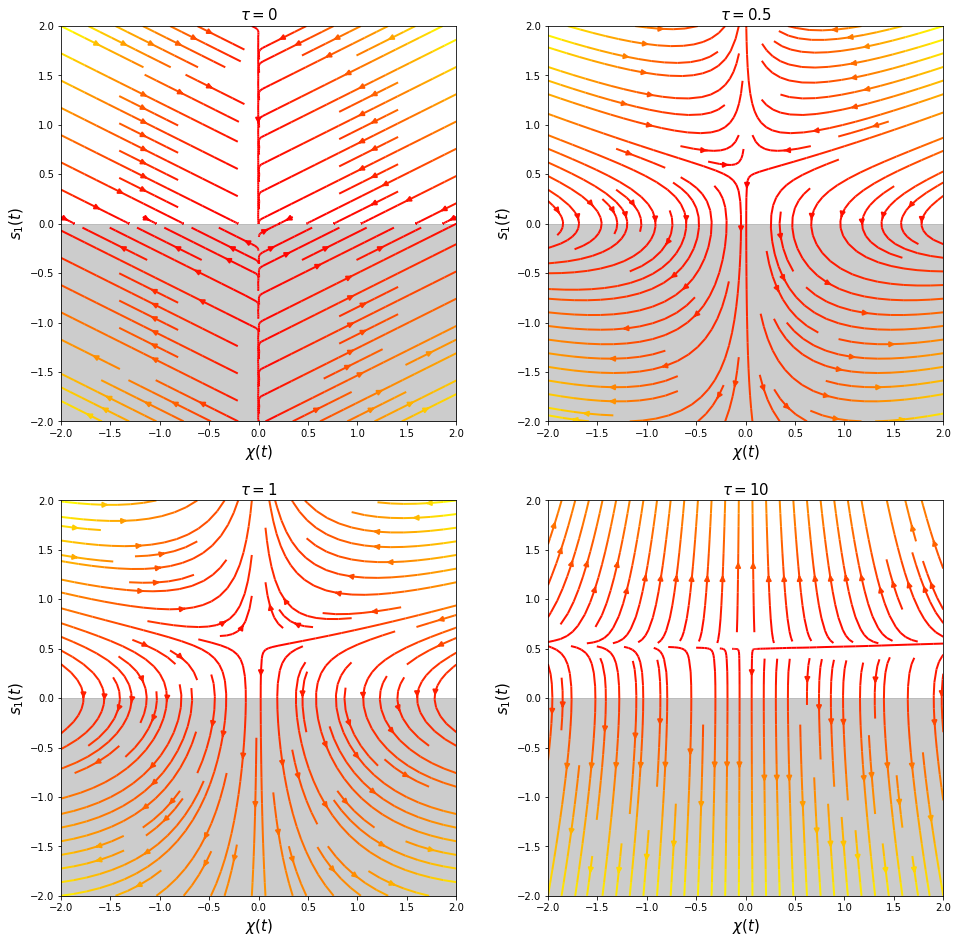

In [41]:
xlim = (-2, 2)
ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0,0.5,1,10]):
    ax = plt.subplot(2,2,1+i)
    
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,1],[C,1],[tau, val],[alpha,1]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\tau=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

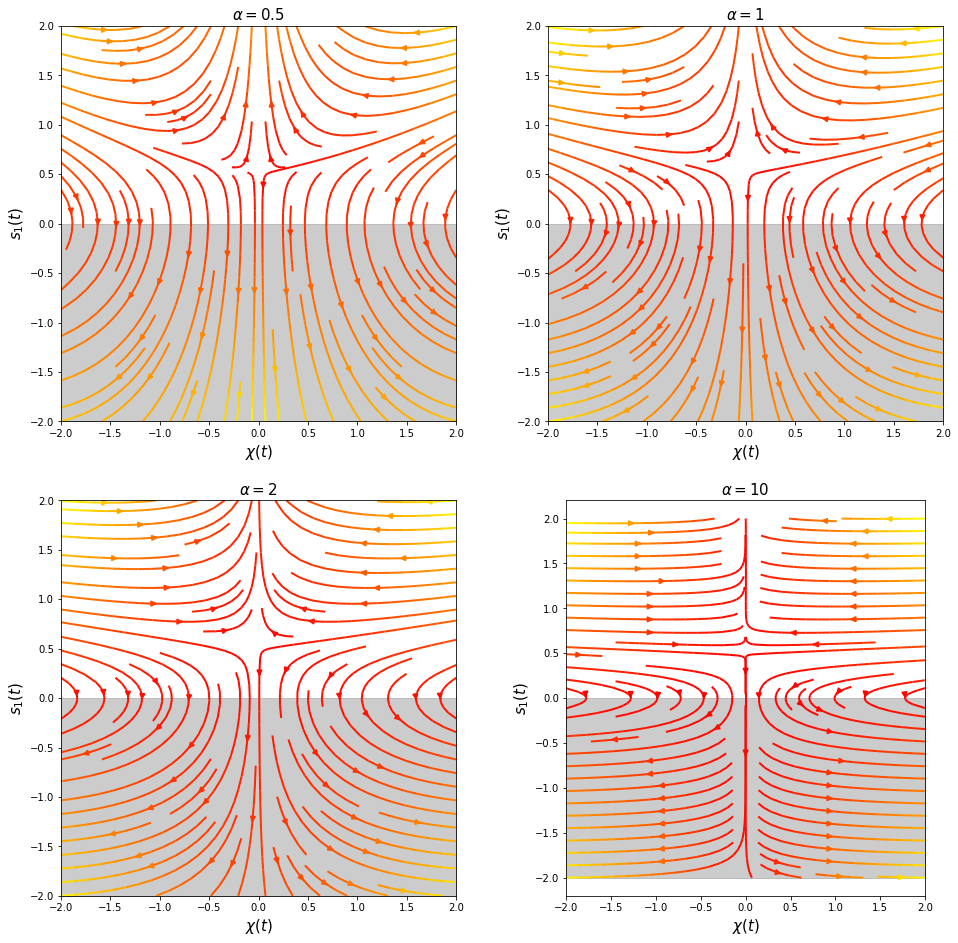

In [42]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0.5,1,2,10]):
    ax = plt.subplot(2,2,1+i)
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,1],[C,1],[tau, 1],[alpha,val]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\alpha=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

In this model we can have transitions to negative edge weights. This is because the edge-density correction term acts on all edge weights equally.

# 3 Model with constant in-degrees

## 3.1. Model equations

$$\begin{align}\dot x &= -Lx \\
\alpha\dot A^{(\textrm{full})}_{ij} &= A^{(\textrm{full})}_{ij}(\tau-(|x_i-x_j|)^p)-(N-1)^{-1}\sum_{\substack{1\leq j\leq N\\j\neq i}}A^{(\textrm{full})}_{ij}(\tau-(|x_i-x_j|)^p)\,.\end{align}$$

Note that the previous two models preserve symmetry of initial network structure. This one can potentially break that symmetry.

## 3.2 The $n$-block case:

$$\begin{align}\dot x &= -Lx \\
\alpha\dot A_{ij} &= A_{ij}(\tau-(|x_i-x_j|)^p)-\frac{1}{n}\sum_{\substack{1\leq j\leq n}}A_{ij}(\tau-(|x_i-x_j|)^p)\,.\end{align}$$

## 3.3 The 2-block case

### 3.3.1 Model equations

In [46]:
# Define general system

# system size (number of blocks)
n = 2

# define parameters
alpha, tau = sy.symbols(r'\alpha'), sy.symbols(r'\tau')

# define variables
t = sy.symbols('t')
x = [Function('x_'+str(i+1))(t) for i in range(n)]
A = [[Function('A_{'+str(i+1)+','+str(j+1)+'}')(t) for j in range(n)] for i in range(n)]

# define equations
# equations for x
x_eqs = [Eq(Derivative(x[i],t), -mvmult(laplace_matrix(A, degree='in'),x)[i]) for i in range(n)]
# equations for A
c = [(sum([A[i][j]*(tau-distance_matrix(x)[i][j]) for j in range(n)])
      #-A[i][i]*(tau-distance_matrix(x)[i][i])
      )/n for i in range(n) ]
A_eqs = [Eq(Derivative(A[i][j],t),sy.simplify(alpha**(-1)*(A[i][j]*(tau-distance_matrix(x)[i][j])-c[i]))) 
         for i in range(n) for j in range(n)]
# all equations
system = x_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(x_1(t), t), -A_{1,2}(t)*x_1(t) + A_{1,2}(t)*x_2(t))

Eq(Derivative(x_2(t), t), A_{2,1}(t)*x_1(t) - A_{2,1}(t)*x_2(t))

Eq(Derivative(A_{1,1}(t), t), (\tau*A_{1,1}(t) - (\tau - Abs(x_1(t) - x_2(t))**p)*A_{1,2}(t))/(2*\alpha))

Eq(Derivative(A_{1,2}(t), t), (-\tau*A_{1,1}(t) + (\tau - Abs(x_1(t) - x_2(t))**p)*A_{1,2}(t))/(2*\alpha))

Eq(Derivative(A_{2,1}(t), t), (-\tau*A_{2,2}(t) + (\tau - Abs(x_1(t) - x_2(t))**p)*A_{2,1}(t))/(2*\alpha))

Eq(Derivative(A_{2,2}(t), t), (\tau*A_{2,2}(t) - (\tau - Abs(x_1(t) - x_2(t))**p)*A_{2,1}(t))/(2*\alpha))

### 3.3.2 Model reduction

#### 3.3.2.1 Discordance variable
Substitute $\chi=x_1-x_2$ into system of equations.

In [47]:
# define variable
chi = Function(r'\chi', real=True)(t)
# define equations
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(x[0],chi+x[1])))]
# equations for A
c = [(sum([A[i][j]*(tau-distance_matrix(x)[i][j]) for j in range(n)]))/n for i in range(n) ]
A_eqs = [Eq(Derivative(A[i][j],t),
            sy.simplify(alpha**(-1)*(A[i][j]*(tau-distance_matrix(x)[i][j])-c[i]))).subs(x[0]-x[1],chi) 
         for i in range(n) for j in range(n)]
# all equations
system = chi_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -(A_{1,2}(t) + A_{2,1}(t))*\chi(t))

Eq(Derivative(A_{1,1}(t), t), (\tau*A_{1,1}(t) - (\tau - Abs(\chi(t))**p)*A_{1,2}(t))/(2*\alpha))

Eq(Derivative(A_{1,2}(t), t), (-\tau*A_{1,1}(t) + (\tau - Abs(\chi(t))**p)*A_{1,2}(t))/(2*\alpha))

Eq(Derivative(A_{2,1}(t), t), (-\tau*A_{2,2}(t) + (\tau - Abs(\chi(t))**p)*A_{2,1}(t))/(2*\alpha))

Eq(Derivative(A_{2,2}(t), t), (\tau*A_{2,2}(t) - (\tau - Abs(\chi(t))**p)*A_{2,1}(t))/(2*\alpha))

#### 3.3.2.2 Transform $A$ variables

Do a transformation 

$$\begin{align}
s_1:&=A_{12}+A_{21}\\
s_2:&=A_{11}+A_{22}\\
d_1:&=A_{12}-A_{21}\\
d_2:&=A_{11}-A_{22}
\end{align}$$

In [48]:
# define equations
subs = {x[0] : chi+x[1], A[0][1] : s1-A[1][0], A[0][0] : s2-A[1][1], A[1][0] : (s1-d1)/2, A[1][1] : (s2-d2)/2}
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(subs)))]
# equations for A
sd_eqs = [Eq(Derivative(s1), sy.simplify((A_eqs[1].rhs+A_eqs[2].rhs).subs(subs))),
          Eq(Derivative(s2), sy.simplify((A_eqs[0].rhs+A_eqs[3].rhs).subs(subs))),
          Eq(Derivative(d1), sy.simplify((A_eqs[1].rhs-A_eqs[2].rhs).subs(subs))),
          Eq(Derivative(d2), sy.simplify((A_eqs[0].rhs-A_eqs[3].rhs).subs(subs)))]
#A_eqs = [[Eq(Derivative(A[i][j],t), alpha**(-1)*A[i][j]*(tau-Abs(chi)**p)) for i in range(n) for j in range(n) if j!=i][0]]
# all equations
system = chi_eqs + sd_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -\chi(t)*s_1(t))

Eq(Derivative(s_1(t), t), (\tau*s_1(t) - \tau*s_2(t) - s_1(t)*Abs(\chi(t))**p)/(2*\alpha))

Eq(Derivative(s_2(t), t), (-\tau*s_1(t) + \tau*s_2(t) + s_1(t)*Abs(\chi(t))**p)/(2*\alpha))

Eq(Derivative(d_1(t), t), (\tau*d_1(t) - \tau*d_2(t) - d_1(t)*Abs(\chi(t))**p)/(2*\alpha))

Eq(Derivative(d_2(t), t), (-\tau*d_1(t) + \tau*d_2(t) + d_1(t)*Abs(\chi(t))**p)/(2*\alpha))

This transformation decoupled the differences from the sums. The triple $(\chi, s_1, s_2)$ are the driving equations.

#### 3.3.2.3 Conservation of in-degree

The model preserves each node's in-degree. For symmetric initial conditions for $A$, it thus also preserves out-degree.

In [49]:
sy.simplify(system[1].rhs+system[2].rhs)

0

So, we are again down to two equations to describe the dynamics:

In [51]:
# define equations
subs = {x[0] : chi+x[1], A[0][1] : s1-A[1][0], A[0][0] : s2-A[1][1], A[1][0] : (s1-d1)/2, A[1][1] : (s2-d2)/2, s2: C-s1}
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(subs)))]
# equations for s and d
sd_eqs = [Eq(Derivative(s1), sy.simplify(sy.collect(sy.expand((A_eqs[1].rhs+A_eqs[2].rhs).subs(subs)),s1)))]
# all equations
system = chi_eqs + sd_eqs

# show equations
for i, eq in enumerate(system):
    system[i] = Eq(eq.lhs, sy.simplify(sy.collect(sy.expand(
        (eq.rhs).subs(A[1][1],A[0][0]).subs(A[1][0],A[0][1]).subs(A[0][0],C-A[0][1])),A[0][1])))
    
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -\chi(t)*s_1(t))

Eq(Derivative(s_1(t), t), (-C*\tau + 2*\tau*s_1(t) - s_1(t)*Abs(\chi(t))**p)/(2*\alpha))

This model is identical to the reduced model in section Section 2.4.

## 3.4 Results for model with in-degree conservation

see section 2.4 because in the symmetric 2-block model the results are the same. But does that mean we get negative edge weights here too?

# 4 Model with saturating edge weights

## 4.1. Model equations

$$\begin{align}\dot x &= -Lx \\
\alpha\dot A^{(\textrm{full})}_{ij} &= A^{(\textrm{full})}_{ij}(1-A^{(\textrm{full})}_{ij})(\tau-(|x_i-x_j|)^p)\,.\end{align}$$

Note that the previous two models preserve symmetry of initial network structure. This one can potentially break that symmetry.

## 4.2 The $n$-block case:

$$\begin{align}\dot x &= -Lx \\
\alpha\dot A_{ij} &= A_{ij}(1-A_{ij})(\tau-(|x_i-x_j|)^p)\,.\end{align}$$

## 4.3 The 2-block case

### 4.3.1 Model equations

In [30]:
# Define general system

# system size (number of blocks)
n = 2

# define parameters
alpha, tau = sy.symbols(r'\alpha'), sy.symbols(r'\tau')

# define variables
t = sy.symbols('t')
x = [Function('x_'+str(i+1))(t) for i in range(n)]
A = [[Function('A_{'+str(i+1)+','+str(j+1)+'}')(t) for j in range(n)] for i in range(n)]

# define equations
# equations for x
x_eqs = [Eq(Derivative(x[i],t), -mvmult(laplace_matrix(A, degree='in'),x)[i]) for i in range(n)]
# equations for A
A_eqs = [Eq(Derivative(A[i][j],t),sy.simplify(alpha**(-1)*(A[i][j]*(1-A[i][j])*(tau-distance_matrix(x)[i][j])))) 
         for i in range(n) for j in range(n)]
# all equations
system = x_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(x_1(t), t), -A_{1,2}(t)*x_1(t) + A_{1,2}(t)*x_2(t))

Eq(Derivative(x_2(t), t), A_{2,1}(t)*x_1(t) - A_{2,1}(t)*x_2(t))

Eq(Derivative(A_{1,1}(t), t), \tau*(1 - A_{1,1}(t))*A_{1,1}(t)/\alpha)

Eq(Derivative(A_{1,2}(t), t), -(\tau - Abs(x_1(t) - x_2(t))**p)*(A_{1,2}(t) - 1)*A_{1,2}(t)/\alpha)

Eq(Derivative(A_{2,1}(t), t), -(\tau - Abs(x_1(t) - x_2(t))**p)*(A_{2,1}(t) - 1)*A_{2,1}(t)/\alpha)

Eq(Derivative(A_{2,2}(t), t), \tau*(1 - A_{2,2}(t))*A_{2,2}(t)/\alpha)

### 4.3.2 Model reduction

#### 4.3.2.1 Discordance variable
Substitute $\chi=x_1-x_2$ into system of equations.

In [56]:
# define variable
chi = Function(r'\chi', real=True)(t)
# define equations
# equations for x
#chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(x[0],chi+x[1])))]
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(x[0],chi+x[1])))]
# equations for A
A_eqs = [Eq(Derivative(A[i][j],t),
            sy.simplify(alpha**(-1)*(A[i][j]*(1-A[i][j])
                                     *(tau-distance_matrix(x)[i][j])).subs(x[0]-x[1],chi))) 
         for i in range(n) for j in range(n)]

# all equations
system = chi_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -(A_{1,2}(t) + A_{2,1}(t))*\chi(t))

Eq(Derivative(A_{1,1}(t), t), \tau*(1 - A_{1,1}(t))*A_{1,1}(t)/\alpha)

Eq(Derivative(A_{1,2}(t), t), -(\tau - Abs(\chi(t))**p)*(A_{1,2}(t) - 1)*A_{1,2}(t)/\alpha)

Eq(Derivative(A_{2,1}(t), t), -(\tau - Abs(\chi(t))**p)*(A_{2,1}(t) - 1)*A_{2,1}(t)/\alpha)

Eq(Derivative(A_{2,2}(t), t), \tau*(1 - A_{2,2}(t))*A_{2,2}(t)/\alpha)

#### 4.3.2.2 Separating subspace of in-group edge weights

In [57]:
# define variable
chi = Function(r'\chi', real=True)(t)
# define equations
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(x[0],chi+x[1])))]
# equations for A
A_eqs = [Eq(Derivative(A[i][j],t),
            sy.simplify(alpha**(-1)*(A[i][j]*(1-A[i][j])
                                     *(tau-distance_matrix(x)[i][j])).subs(x[0]-x[1],chi))) 
         for i in range(n) for j in range(n) if i!=j]

# all equations
system = chi_eqs + A_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -(A_{1,2}(t) + A_{2,1}(t))*\chi(t))

Eq(Derivative(A_{1,2}(t), t), -(\tau - Abs(\chi(t))**p)*(A_{1,2}(t) - 1)*A_{1,2}(t)/\alpha)

Eq(Derivative(A_{2,1}(t), t), -(\tau - Abs(\chi(t))**p)*(A_{2,1}(t) - 1)*A_{2,1}(t)/\alpha)

#### 4.3.2.3 Transform $A$ variables

Do a transformation 

$$\begin{align}
s_1:&=A_{12}+A_{21}\\
d_1:&=A_{12}-A_{21}
\end{align}$$

In [59]:
# define equations
subs = {x[0] : chi+x[1], A[0][1] : s1-A[1][0], A[1][0] : (s1-d1)/2}
# equations for x
chi_eqs = [Eq(Derivative(chi,t), sy.simplify((x_eqs[0].rhs-x_eqs[1].rhs).subs(subs)))]
# equations for A
sd_eqs = [Eq(Derivative(s1), sy.simplify((A_eqs[0].rhs+A_eqs[1].rhs).subs(subs))),
          Eq(Derivative(d1), sy.simplify((A_eqs[0].rhs-A_eqs[1].rhs).subs(subs)))]
#A_eqs = [[Eq(Derivative(A[i][j],t), alpha**(-1)*A[i][j]*(tau-Abs(chi)**p)) for i in range(n) for j in range(n) if j!=i][0]]
# all equations
system = chi_eqs + sd_eqs

# show equations
for eq in system:
    display(eq)

Eq(Derivative(\chi(t), t), -\chi(t)*s_1(t))

Eq(Derivative(s_1(t), t), -(\tau - Abs(\chi(t))**p)*((d_1(t) - s_1(t))*(d_1(t) - s_1(t) + 2) + (d_1(t) + s_1(t))*(d_1(t) + s_1(t) - 2))/(4*\alpha))

Eq(Derivative(d_1(t), t), (-\tau*s_1(t) + \tau + s_1(t)*Abs(\chi(t))**p - Abs(\chi(t))**p)*d_1(t)/\alpha)

This does not look like a good transformation.

## 4.4 Results for model with total-edge-weight conservation

### 4.4.1 Results for $p=2$

In [ ]:
X = Matrix([chi, s1])
FX = Matrix([system[i].rhs for i in range(2)])
J2 = FX.subs(p,2).jacobian(X)
display(J2)

In [ ]:
xlim = (-2, 2)
ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0,0.5,1,10]):
    ax = plt.subplot(2,2,1+i)
    
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    ax.fill_between(list(xlim), [1,1], [ylim[1]]*2, alpha=0.4, color='gray')
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,2],[C,1],[tau, val],[alpha,1]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\tau=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

In [ ]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0.5,1,2,10]):
    ax = plt.subplot(2,2,1+i)
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    ax.fill_between(list(xlim), [1,1], [ylim[1]]*2, alpha=0.4, color='gray')
    
    vec = [chi, s1]
    u, v = vectorfield2d(system, vec, parameters=[[p,2],[C,1],[tau, 1],[alpha,val]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\alpha=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

### 4.4.2 Results for $p=1$

In [ ]:
X = Matrix([chi, A[0][1]])
FX = Matrix([system[i].rhs for i in range(2)])
J1 = FX.subs(p,1).jacobian(X)
display(J1)

In [ ]:
xlim = (-2, 2)
ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0,0.1,0.5,1]):
    ax = plt.subplot(2,2,1+i)
    
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    ax.fill_between(list(xlim), [1,1], [ylim[1]]*2, alpha=0.4, color='gray')
    vec = [chi, A[0][1]]
    u, v = vectorfield2d(system, vec, parameters=[[p,1],[C,1],[tau, val],[alpha,1]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\tau=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

In [ ]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

for i, val in enumerate([0.1,0.5,1,2]):
    ax = plt.subplot(2,2,1+i)
    ax.fill_between(list(xlim), [ylim[0]]*2, [0,0], alpha=0.4, color='gray')
    ax.fill_between(list(xlim), [1,1], [ylim[1]]*2, alpha=0.4, color='gray')
    
    vec = [chi, A[0][1]]
    u, v = vectorfield2d(system, vec, parameters=[[p,1],[C,1],[tau, 1],[alpha,val]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\alpha=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[1])+'$', fontsize=15)

---------------------------------------
# Stubs
### 3d system

In [40]:
display(J2.subs(chi,0))

Matrix([
[-2*A_{1,2}(t),                                                      0],
[            0, -\tau*(A_{1,2}(t) - 1)/\alpha - \tau*A_{1,2}(t)/\alpha]])

In this case, the dynamics of $A_{1,2}$ and $A_{2,1}$ are not coupled. Both edge weights grow exponentially with growth rate $\tau$. How do these things change when a small discordance is introduced? Might need to look at the second derivative. When $\tau=0$, all points in this plane become unstable(?) fixed points.

2. $A_{1,2}=A_{2,1}=0$

In [41]:
display(J2.subs(A[0][1],0).subs(A[1][0],0))

Matrix([
[0,                 -2*\chi(t)],
[0, (\tau - \chi(t)**2)/\alpha]])

In this case, $\chi$ does not change. Any point on this line is a fixed point with at least (?) one stable direction.

3. $|\chi|^p=\tau$

In [42]:
display(J2.subs(chi,sqrt(tau)))

Matrix([
[                                  -2*A_{1,2}(t), -2*sqrt(\tau)],
[2*sqrt(\tau)*(A_{1,2}(t) - 1)*A_{1,2}(t)/\alpha,             0]])

In this case, the edge weights don't change. However, $\chi$ still changes with time and thus we move out of this manifold and into a part of the state space in which $A_{1,2}$ and $A_{2,1}$ are changing.

### What do the dynamics look like when $\tau=0$?

NameError: name 'vector_field' is not defined

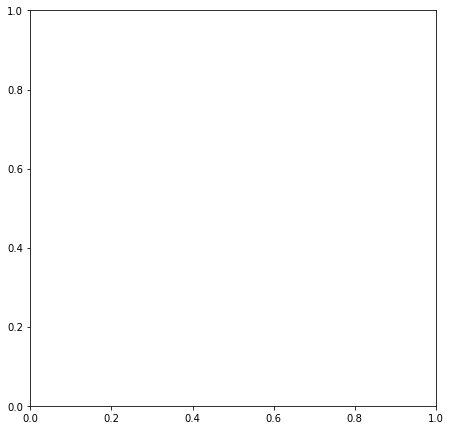

In [43]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

# tau = 0
for i, val in enumerate([0,0.5,1,10]):
    ax = plt.subplot(2,2,1+i)
        
    vec = [chi, A[0][1], A[1][0]]
    indices = [0,1]
    u, v = vector_field(J2, vec, indices=indices, parameters=[[tau, 0],[A[1][0],val]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$A_{2,1}=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[indices[0]])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[indices[1]])+'$', fontsize=15)

In [ ]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

# tau = 0
for i, val in enumerate([0,0.5,1,10]):
    ax = plt.subplot(2,2,1+i)
        
    vec = [chi, A[0][1], A[1][0]]
    indices = [1,2]
    u, v = vector_field(J2, vec, indices=indices, parameters=[[tau, 0],[chi,val]])
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$\chi=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[indices[0]])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[indices[1]])+'$', fontsize=15)

### Non-zero $\tau$

In [ ]:
xlim = ylim = (-2, 2)
fig = plt.figure(figsize=(16, 16))

# tau = 0
for i, val in enumerate([0,0.5,1,10]):
    ax = plt.subplot(2,2,1+i)
        
    vec = [chi, A[0][1], A[1][0]]
    indices = [0,1]
    u, v = vector_field(J2, vec, indices=indices, parameters=[[tau, 1],[A[1][0],val]])
    
    plot_streamlines(ax, u, v, xlim, ylim)
    
    ax.set_aspect('equal')
    ax.set_title(r'$A_{2,1}=$'+str(val), fontsize=15)
    ax.set_xlabel(r'$'+str(vec[indices[0]])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(vec[indices[1]])+'$', fontsize=15)